In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F

import simcube

from simcube.data import \
    tokenize_corpus, \
    build_vocabulary, \
    texts_to_token_ids, \
    PaddedSequenceDataset, \
    Embeddings

from simcube.pipeline import \
    train_eval_loop, \
    predict_with_model, \
    init_random_seed

from simcube.visualization import plot_vectors

init_random_seed()

## Загрузка данных и подготовка корпуса

In [2]:
full_dataset = list(pd.read_csv('../../data/raw/nyt-ingredients-snapshot-2015.csv')['input'].dropna())
random.shuffle(full_dataset)

TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.7)
train_source = full_dataset[:TRAIN_VAL_SPLIT]
test_source = full_dataset[TRAIN_VAL_SPLIT:]
print("Обучающая выборка", len(train_source))
print("Тестовая выборка", len(test_source))
print()
print('\n'.join(train_source[:10]))

Обучающая выборка 125344
Тестовая выборка 53719

1/4 cup sour cream
10 ounces swordfish, red snapper or other firm-fleshed fish
1 tablespoon minced basil leaves
Handful fresh parsley, finely minced
4 ounces lard or butter, plus more for brushing tops
4 to 5 green cardamom pods
1 stick ( 1/4 pound) unsalted butter, softened
1/4 teaspoon red pepper flakes, preferably Turkish or Aleppo (see note), more to taste
1 tablespoon fresh lemon juice
1/4 cup scallions, thinly sliced


In [5]:
# Дистрибутивная семантика
# эта наука занимается изучением смыслов слов
# Смысл слова описывается тем контестом, в котором слово обычно употребляется

# Методы дистрибутивной семантики пытаются извлечь смысл слов, анализируя распределения
# вероятностей совместной встречаемости слов в рамках одго фрагмента текста 
# или вероятностей встретить одни слова в контексте других

In [6]:
# токенизируем
train_tokenized = tokenize_corpus(train_source)
test_tokenized = tokenize_corpus(test_source)
print('\n'.join(' '.join(sent) for sent in train_tokenized[:10]))

sour cream
ounces swordfish snapper other firm fleshed fish
tablespoon minced basil leaves
handful fresh parsley finely minced
ounces lard butter plus more brushing tops
green cardamom pods
stick pound unsalted butter softened
teaspoon pepper flakes preferably turkish aleppo note more taste
tablespoon fresh lemon juice
scallions thinly sliced


In [7]:
# строим словарь
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=0.9, min_count=5, pad_word='<PAD>')
print("Размер словаря", len(vocabulary))
print(list(vocabulary.items())[:10])

Размер словаря 2267
[('<PAD>', 0), ('tablespoons', 1), ('teaspoon', 2), ('chopped', 3), ('salt', 4), ('pepper', 5), ('cups', 6), ('ground', 7), ('fresh', 8), ('tablespoon', 9)]


In [8]:
# отображаем в номера токенов
train_token_ids = texts_to_token_ids(train_tokenized, vocabulary)
test_token_ids = texts_to_token_ids(test_tokenized, vocabulary)

print('\n'.join(' '.join(str(t) for t in sent) for sent in train_token_ids[:10]))

222 52
22 878 574 127 246 707 181
9 19 88 33
517 8 43 15 19
22 586 20 45 47 648 649
59 329 535
200 12 50 20 266
2 5 140 78 1208 735 153 47 10
9 8 31 25
98 65 27


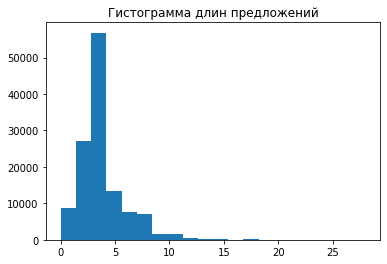

In [9]:
plt.hist([len(s) for s in train_token_ids], bins=20);
plt.title('Гистограмма длин предложений');

In [11]:
MAX_SENTENCE_LEN = 20
train_dataset = PaddedSequenceDataset(train_token_ids,
                                      np.zeros(len(train_token_ids)),
                                      out_len=MAX_SENTENCE_LEN)
test_dataset = PaddedSequenceDataset(test_token_ids,
                                     np.zeros(len(test_token_ids)),
                                     out_len=MAX_SENTENCE_LEN)

In [12]:
print(train_dataset[0])

(tensor([222,  52,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]), tensor(0))


In [13]:
print(train_dataset[1])

(tensor([ 22, 878, 574, 127, 246, 707, 181,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]), tensor(0))


## Алгоритм обучения - Skip Gram Negative Sampling

In [57]:
# Skip Gram - моделирует распределение соседей при условии центрального слова
# CBOW, continuous bag of words - моделирует распределение центрального слова при условии известных соседей

In [14]:
# Skip Gram - предсказываем соседние слова по центральному слову
# Negative Sampling - аппроксимация softmax

In [15]:
def make_diag_mask(size, radius):
    """Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали"""
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask

In [16]:
make_diag_mask(10, 3)

tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

In [17]:
class SkipGramNegativeSamplingTrainer(nn.Module):
    def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.center_emb.weight.data[0] = 0

        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)        
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0

        self.positive_sim_mask = make_diag_mask(sentence_len, radius)
    
    def forward(self, sentences):
        """sentences - Batch x MaxSentLength - идентификаторы токенов"""
        batch_size = sentences.shape[0]
        center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

        # оценить сходство с настоящими соседними словами
        positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
        positive_probs = torch.sigmoid(positive_sims)

        # увеличить оценку вероятности встретить эти пары слов вместе
        positive_mask = self.positive_sim_mask.to(positive_sims.device)
        positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                               positive_mask.expand_as(positive_probs))

        # выбрать случайные "отрицательные" слова
        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN
        
        # уменьшить оценку вероятность встретить эти пары слов вместе
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))

        return positive_loss + negative_loss


def no_loss(pred, target):
    """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
    return pred

## Обучение

In [21]:
trainer = SkipGramNegativeSamplingTrainer(
    len(vocabulary), 
    100, 
    MAX_SENTENCE_LEN, 
    radius=5, 
    negative_samples_n=25
)

In [23]:
%%time

best_val_loss, best_model = train_eval_loop(trainer, train_dataset, test_dataset,
    no_loss,
    lr=1e-2,
    epoch_n=2,
    batch_size=8,
    early_stopping_patience=10,
    max_batches_per_epoch_train=2000,
    max_batches_per_epoch_val=len(test_dataset),
    lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True)
)

Выбранное устройство: cuda
Эпоха 0
Эпоха: 2001 итераций, 6.05 сек
Среднее значение функции потерь на обучении 0.879846481875382
Среднее значение функции потерь на валидации 0.8782594562464477
Новая лучшая модель!

Эпоха 1
Эпоха: 2001 итераций, 5.21 сек
Среднее значение функции потерь на обучении 0.8781611629273521
Среднее значение функции потерь на валидации 0.8777611416307565
Новая лучшая модель!

CPU times: user 23.9 s, sys: 734 ms, total: 24.7 s
Wall time: 24.5 s


In [26]:
torch.save(trainer.state_dict(), '../../data/models/sgns.pth')

In [27]:
trainer.load_state_dict(torch.load('../../data/models/sgns.pth'))

<All keys matched successfully>

## Исследуем характеристики полученных векторов

In [28]:
embeddings = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

In [29]:
embeddings.most_similar('chicken')

[('chicken', 0.9999339),
 ('broth', 0.5569482),
 ('stock', 0.53195727),
 ('turkey', 0.51217765),
 ('breast', 0.50822675),
 ('skinless', 0.45503742),
 ('boneless', 0.45112085),
 ('quarts', 0.44986263),
 ('duck', 0.43958414),
 ('sodium', 0.41927022)]

In [30]:
embeddings.most_similar('coffee')

[('coffee', 0.9999544),
 ('masa', 0.3695662),
 ('sifted', 0.3660916),
 ('grained', 0.3592787),
 ('instant', 0.35635707),
 ('praline', 0.35306114),
 ('fancy', 0.3171711),
 ('grainy', 0.31357557),
 ('breads', 0.30714795),
 ('espresso', 0.3030763)]

In [31]:
embeddings.analogy('cake', 'cacao', 'cheese')

[('cacao', 0.9918212),
 ('cheese', 0.9071052),
 ('cottage', 0.7697627),
 ('chocolate', 0.71812797),
 ('valrhona', 0.6817431),
 ('goat', 0.6635976),
 ('stew', 0.6351927),
 ('monterey', 0.6309929),
 ('although', 0.62445354),
 ('crema', 0.6236236)]

In [32]:
test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 
              'cake', 'coffee', 'sausage', 'wine', 'merlot', 'zinfandel', 
              'trout', 'chardonnay', 'champagne', 'cacao']
test_vectors = embeddings.get_vectors(*test_words)
print(test_vectors.shape)

(18, 100)


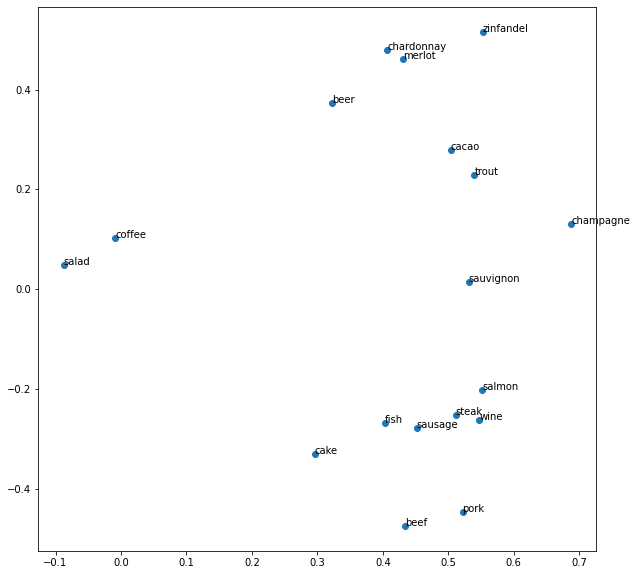

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)

## Обучение Word2Vec с помощью Gensim

In [34]:
import gensim

In [36]:
%%time

word2vec = gensim.models.Word2Vec(
    sentences=train_tokenized, 
    size=100,
    window=5, 
    min_count=5, 
    workers=24,
    sg=1, 
    iter=10
)

CPU times: user 18.3 s, sys: 120 ms, total: 18.4 s
Wall time: 5.24 s


In [37]:
word2vec.wv.most_similar('chicken')

[('duck', 0.7388399839401245),
 ('thighs', 0.7044893503189087),
 ('pheasant', 0.693988025188446),
 ('simmering', 0.6856342554092407),
 ('drumsticks', 0.682977557182312),
 ('turkey', 0.6816940903663635),
 ('defatted', 0.6567668914794922),
 ('breasts', 0.6559194326400757),
 ('rabbit', 0.6544360518455505),
 ('chickens', 0.6531239748001099)]

In [38]:
word2vec.wv.most_similar('coffee')

[('espresso', 0.871442437171936),
 ('brewed', 0.7680679559707642),
 ('instant', 0.6789559721946716),
 ('process', 0.6784331798553467),
 ('grinder', 0.6719653010368347),
 ('spices', 0.6662553548812866),
 ('west', 0.6434237957000732),
 ('garam', 0.6430879831314087),
 ('dutch', 0.6400915384292603),
 ('sweetened', 0.6370556354522705)]

In [39]:
gensim_words = [w for w in test_words if w in word2vec.wv.vocab]
gensim_vectors = np.stack([word2vec.wv[w] for w in gensim_words])

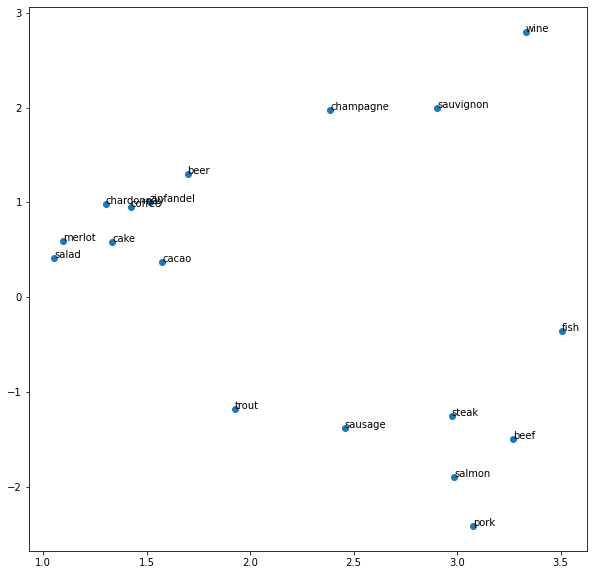

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(gensim_vectors, test_words, how='svd', ax=ax)

## Загрузка предобученного Word2Vec

Источники готовых векторов:

https://rusvectores.org/ru/ - для русского языка

https://wikipedia2vec.github.io/wikipedia2vec/pretrained/ - много разных языков

In [42]:
import gensim.downloader as api

In [43]:
available_models = api.info()['models'].keys()
print('\n'.join(available_models))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [44]:
api.info()

{'corpora': {'semeval-2016-2017-task3-subtaskBC': {'num_records': -1,
   'record_format': 'dict',
   'file_size': 6344358,
   'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/semeval-2016-2017-task3-subtaskB-eng/__init__.py',
   'license': 'All files released for the task are free for general research use',
   'fields': {'2016-train': ['...'],
    '2016-dev': ['...'],
    '2017-test': ['...'],
    '2016-test': ['...']},
   'description': 'SemEval 2016 / 2017 Task 3 Subtask B and C datasets contain train+development (317 original questions, 3,169 related questions, and 31,690 comments), and test datasets in English. The description of the tasks and the collected data is given in sections 3 and 4.1 of the task paper http://alt.qcri.org/semeval2016/task3/data/uploads/semeval2016-task3-report.pdf linked in section “Papers” of https://github.com/RaRe-Technologies/gensim-data/issues/18.',
   'checksum': '701ea67acd82e75f95e1d8e62fb0ad29',
   'file_name': 'se

In [46]:
len(api.info()["corpora"])

10

In [48]:
api.info()["models"]

{'fasttext-wiki-news-subwords-300': {'num_records': 999999,
  'file_size': 1005007116,
  'base_dataset': 'Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens)',
  'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/fasttext-wiki-news-subwords-300/__init__.py',
  'license': 'https://creativecommons.org/licenses/by-sa/3.0/',
  'parameters': {'dimension': 300},
  'description': '1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).',
  'read_more': ['https://fasttext.cc/docs/en/english-vectors.html',
   'https://arxiv.org/abs/1712.09405',
   'https://arxiv.org/abs/1607.01759'],
  'checksum': 'de2bb3a20c46ce65c9c131e1ad9a77af',
  'file_name': 'fasttext-wiki-news-subwords-300.gz',
  'parts': 1},
 'conceptnet-numberbatch-17-06-300': {'num_records': 1917247,
  'file_size': 1225497562,
  'base_dataset': 'ConceptNet, word2vec, GloVe, and OpenSubtitles 2016',
  'reader_code': 'https:/

In [49]:
pretrained = api.load('word2vec-google-news-300')

[--------------------------------------------------] 0.0% 0.0/1662.8MB downloaded

KeyboardInterrupt: 

In [ ]:
pretrained.most_similar('cheese')

In [ ]:
pretrained.most_similar(positive=['man', 'queen'], negative=['king'])

In [ ]:
pretrained_words = [w for w in test_words if w in pretrained.vocab]
pretrained_vectors = np.stack([pretrained[w] for w in pretrained_words])

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(pretrained_vectors, test_words, how='svd', ax=ax)

## Заключение
Реализовали Skip Gram Negative Sampling на PyTorch

Обучили на корпусе рецептов

Сходство слов модель выучила неплохо

Для аналогий мало данных

Обучили SGNS с помощью библиотеки Gensim

Загрузили веса Word2Vec, полученные с помощью большого корпуса (GoogleNews)

Списки похожих слов отличаются!

Аналогии работают